In [1]:
!pip install google-api-python-client
!pip install networkx
!pip install requests
!pip install numpy
!pip install python-louvain
!pip install feel-it

import os
import networkx as nx
import numpy as np
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import community as cm
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
import dateutil.parser
import pickle
from feel_it import EmotionClassifier
from feel_it import SentimentClassifier



nltk.download('punkt')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 21.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9406 sha256=711d4ef0bd90e9f5907ea97b8dc05f50a1d1159edd18f2a1dab407369f0bde7f
  Stored in directory: /root/

True

In [3]:
# Configura la tua chiave API di YouTube
API_KEY = 'use your API KEY'
CHANNEL_NAME = 'Poketonx'  # Nome del canale da cercare

# Funzione per ottenere l'ID del canale in base al nome
def get_channel_id(api_key, channel_name):
    youtube = build('youtube', 'v3', developerKey=api_key)
    request = youtube.channels().list(
        part='id',
        forUsername=channel_name
    )
    response = request.execute()
    
    if response['items']:
        return response['items'][0]['id']
    else:
        return None

# Funzione per ottenere l'ID della playlist "2024 Summer League"
def get_playlist_id(api_key, channel_id, playlist_title):
    youtube = build('youtube', 'v3', developerKey=api_key)
    playlists = []
    next_page_token = None

    while True:
        playlist_request = youtube.playlists().list(
            part='snippet',
            channelId=channel_id,
            maxResults=50,
            pageToken=next_page_token
        )
        playlist_response = playlist_request.execute()

        for item in playlist_response['items']:
            if playlist_title.lower() in item['snippet']['title'].lower():
                playlists.append((item['id'], item['snippet']['title']))

        next_page_token = playlist_response.get('nextPageToken')
        if not next_page_token:
            break

    return playlists

# Funzione per ottenere i video dalla playlist
def get_playlist_videos(api_key, playlist_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    videos = []
    next_page_token = None

    while True:
        playlist_request = youtube.playlistItems().list(
            part='snippet',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        playlist_response = playlist_request.execute()

        for item in playlist_response['items']:
            video_id = item['snippet']['resourceId']['videoId']
            video_title = item['snippet']['title']
            videos.append((video_id, video_title))

        next_page_token = playlist_response.get('nextPageToken')
        if not next_page_token:
            break

    return videos

# Funzione per ottenere i commenti di un video
def get_video_comments(api_key, video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    next_page_token = None

    while True:
        comment_request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat='plainText',
            maxResults=100,
            pageToken=next_page_token
        )
        comment_response = comment_request.execute()

        for item in comment_response['items']:
            commenter = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            comments.append(commenter)

        next_page_token = comment_response.get('nextPageToken')
        if not next_page_token:
            break

    return comments

# Funzione per creare un grafo bipartito
def crea_grafo_bipartito(video_commenti):
    B = nx.Graph()

    for video_id, video_title in video_commenti:
        B.add_node(video_title, bipartite=0)  # Gruppo 0: video
        
        commentatori = get_video_comments(API_KEY, video_id)
        for utente in commentatori:
            B.add_node(utente, bipartite=1)  # Gruppo 1: utenti
            B.add_edge(video_title, utente)  # Aggiungi arco

    return B

# Main
channel_id = get_channel_id(API_KEY, CHANNEL_NAME)

if channel_id:
    print(f"Trovato ID del canale: {channel_id}")

    playlist_title = "Let's Play Pokemon Platino"  # Titolo della playlist da cercare
    playlists = get_playlist_id(API_KEY, channel_id, playlist_title)

    if playlists:
        playlist_id = playlists[0][0]  # Prendi il primo ID trovato
        print(f"Trovata playlist: {playlists[0][1]} con ID: {playlist_id}")
        
        video_commenti = get_playlist_videos(API_KEY, playlist_id)
        
        # Ottieni i commenti di tutti i video
        grafo = crea_grafo_bipartito(video_commenti)

        # Visualizza informazioni del grafo
        print(f"Nodi totali: {grafo.number_of_nodes()}")
        print(f"Archi totali: {grafo.number_of_edges()}")

    else:
        print("Nessuna playlist trovata con il titolo specificato.")
else:
    print("Nessun canale trovato con il nome specificato.")

Trovato ID del canale: UCDgWexup-gidGR2If_FgIZw
Trovata playlist: Let's Play Pokemon Platino con ID: PLjaqxnA0Ss2vhYz8Jb6dqKXNh1P7bfufu
Nodi totali: 3634
Archi totali: 6055


In [ ]:
# Funzione per proiettare il grafo bipartito in un grafo unipartito degli utenti, pesando i link
def proietta_grafo_utenti_pesato(bipartito):
    # Crea un grafo unipartito per gli utenti
    U = nx.Graph()
    
    # Ottieni tutte le connessioni degli utenti
    for video in bipartito.nodes(data=True):
        if bipartito.nodes[video[0]]['bipartite'] == 0:  # Se è un video
            utenti = list(bipartito.neighbors(video[0]))  # Ottieni i commentatori

            # Aggiungi archi tra utenti che hanno commentato lo stesso video
            for i in range(len(utenti)):
                for j in range(i + 1, len(utenti)):
                    # Se esiste già un arco, incrementa il peso
                    if U.has_edge(utenti[i], utenti[j]):
                        U[utenti[i]][utenti[j]]['weight'] += 1
                    else:
                        U.add_edge(utenti[i], utenti[j], weight=1)  # Aggiungi arco con peso 1
    
    # Rimuovi link con peso minore di 4
    edges_to_remove = [(u, v) for u, v, data in U.edges(data=True) if data['weight'] < 4]
    U.remove_edges_from(edges_to_remove)

    # Rimuovi nodi isolati
    isolated_nodes = list(nx.isolates(U))
    U.remove_nodes_from(isolated_nodes)

    return U

grafo_utenti = proietta_grafo_utenti_pesato(grafo)

# Visualizza informazioni del grafo unipartito
print(f"Nodi totali nel grafo utenti: {grafo_utenti.number_of_nodes()}")
print(f"Archi totali nel grafo utenti: {grafo_utenti.number_of_edges()}")

Nodi totali nel grafo utenti: 239
Archi totali nel grafo utenti: 1117


In [ ]:
# 1. Calcolo della densità
density = nx.density(grafo_utenti)

# 2. Calcolo dei gradi di tutti i nodi
degrees = [grafo_utenti.degree(n) for n in grafo_utenti.nodes()]

# 3. Calcolo del grado medio e mediana
average_degree = np.mean(degrees)
median_degree = np.median(degrees)

# 4. Calcolo del grado massimo e minimo
max_degree = np.max(degrees)
min_degree = np.min(degrees)

# 5. Calcolo della deviazione standard
std_deviation = np.std(degrees)

# Stampa dei risultati
print(f"Densità: {density}")
print(f"Grado Medio: {average_degree}")
print(f"Grado Mediana: {median_degree}")
print(f"Grado Massimo: {max_degree}")
print(f"Grado Minimo: {min_degree}")
print(f"Deviazione Standard: {std_deviation}")

Densità: 0.03927428712070602
Grado Medio: 9.347280334728033
Grado Mediana: 4.0
Grado Massimo: 212
Grado Minimo: 1
Deviazione Standard: 21.15495488140741


In [ ]:
def crea_rete_random(num_nodi, densita):
    """
    Crea una rete casuale utilizzando il modello di Erdős–Rényi.

    :param num_nodi: Numero di nodi nel grafo
    :param densita: Probabilità di esistenza di un arco tra coppie di nodi
    :return: Grafo casuale generato
    """
    # Creazione del grafo casuale
    G = nx.erdos_renyi_graph(num_nodi, densita)
    
    return G

# Esempio di utilizzo della funzione
num_nodi = grafo_utenti.number_of_nodes()   # Numero di nodi
densita = nx.density(grafo_utenti)            # Densità (probabilità di esistenza degli archi)

rete_random = crea_rete_random(num_nodi, densita)
degrees_random = [rete_random.degree(n) for n in rete_random.nodes()]

# Stampa delle informazioni sulla rete random
print(f"Densità: {nx.density(rete_random)}")
print(f"Grado Medio: {np.mean(degrees_random)}")
print(f"Grado Mediana: {np.median(degrees_random)}")
print(f"Grado Massimo: {np.max(degrees_random)}")
print(f"Grado Minimo: {np.min(degrees_random)}")
print(f"Deviazione Standard: {np.std(degrees_random)}")


Densità: 0.036883372595900285
Grado Medio: 8.778242677824268
Grado Mediana: 9.0
Grado Massimo: 21
Grado Minimo: 2
Deviazione Standard: 3.089492830461931


In [ ]:
#Trova i nodi hub in un grafo, considerando il percentile 9 come soglia.
def trova_hub_e_gradi(G):
    # Calcola i gradi di tutti i nodi
    gradi = np.array([G.degree(n) for n in G.nodes()])
    
    # Calcola il valore soglia per il percentile 99
    soglia = np.percentile(gradi, 99)
    
    # Trova i nodi che superano la soglia e il loro grado
    hub = [(n, G.degree(n)) for n in G.nodes() if G.degree(n) > soglia]
    
    return hub, soglia

# Trova gli hub e i loro gradi
hub_nodi_e_gradi, soglia_hub = trova_hub_e_gradi(grafo_utenti)


# Stampa i risultati
print(f"Soglia per il percentile 99: {soglia_hub}")
print("Nodi considerati hub (nodo, grado):")
for nodo, grado in sorted(hub_nodi_e_gradi, key=lambda x: x[1], reverse=True):
    print(f"Nodo: {nodo}, Grado: {grado}")

Soglia per il percentile 99: 104.20000000000027
Nodi considerati hub (nodo, grado):
Nodo: @francescocugliandro9107, Grado: 212
Nodo: @TheDarkslayer0, Grado: 164
Nodo: @fra7161, Grado: 127


In [ ]:
# Calcolo della degree centrality
degree_centrality = nx.degree_centrality(grafo_utenti)

# Stampa dei risultati
print("Degree Centrality dei nodi:")
top_five_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for nodo, centralita in top_five_degree:
    print(f"Nodo: {nodo}, Degree Centrality: {centralita}")


Degree Centrality dei nodi:
Nodo: @francescocugliandro9107, Degree Centrality: 0.8907563025210083
Nodo: @TheDarkslayer0, Degree Centrality: 0.6890756302521008
Nodo: @fra7161, Degree Centrality: 0.5336134453781513
Nodo: @BlackAntoITA, Degree Centrality: 0.2815126050420168
Nodo: @SupremoLordLotad, Degree Centrality: 0.27310924369747897


In [ ]:
# Calcolo e ordinamento della closeness centrality
closeness_centrality = nx.closeness_centrality(grafo_utenti)
top_five_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Stampa delle prime cinque closeness centrality
print("Prime cinque Closeness Centrality:")
for nodo, centralita in top_five_closeness:
    print(f"Nodo: {nodo}, Closeness Centrality: {centralita}")


Prime cinque Closeness Centrality:
Nodo: @francescocugliandro9107, Closeness Centrality: 0.9015151515151515
Nodo: @TheDarkslayer0, Closeness Centrality: 0.7628205128205128
Nodo: @fra7161, Closeness Centrality: 0.6819484240687679
Nodo: @BlackAntoITA, Closeness Centrality: 0.5804878048780487
Nodo: @SupremoLordLotad, Closeness Centrality: 0.5790754257907542


In [ ]:
# Calcolo e ordinamento della betweenness centrality
betweenness_centrality = nx.betweenness_centrality(grafo_utenti)
top_five_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Stampa delle prime cinque betweenness centrality
print("Prime cinque Betweenness Centrality:")
for nodo, centralita in top_five_betweenness:
    print(f"Nodo: {nodo}, Betweenness Centrality: {centralita}")

Prime cinque Betweenness Centrality:
Nodo: @francescocugliandro9107, Betweenness Centrality: 0.5421963726110647
Nodo: @TheDarkslayer0, Betweenness Centrality: 0.2236804459842989
Nodo: @fra7161, Betweenness Centrality: 0.1397501495789981
Nodo: @BlackAntoITA, Betweenness Centrality: 0.025950810892926425
Nodo: @SupremoLordLotad, Betweenness Centrality: 0.017550099812390425


In [ ]:
# Calcolo e ordinamento della eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(grafo_utenti)
top_five_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Stampa delle prime cinque eigenvector centrality
print("Prime cinque Eigenvector Centrality:")
for nodo, centralita in top_five_eigenvector:
    print(f"Nodo: {nodo}, Eigenvector Centrality: {centralita}")

Prime cinque Eigenvector Centrality:
Nodo: @francescocugliandro9107, Eigenvector Centrality: 0.3482942558441069
Nodo: @TheDarkslayer0, Eigenvector Centrality: 0.32145821608413544
Nodo: @fra7161, Eigenvector Centrality: 0.27290216228597525
Nodo: @SupremoLordLotad, Eigenvector Centrality: 0.19678332598931736
Nodo: @thedarkgamers7245, Eigenvector Centrality: 0.19211110412042293


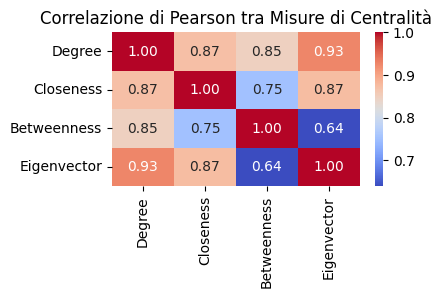

In [ ]:
# Creazione di un DataFrame con le centralità
centralita_df = pd.DataFrame({
    'Degree': degree_centrality.values(),
    'Closeness': closeness_centrality.values(),
    'Betweenness': betweenness_centrality.values(),
    'Eigenvector': eigenvector_centrality.values()
})

# Creazione di una heatmap per visualizzare la correlazione
plt.figure(figsize=(4, 2))
heatmap = sns.heatmap(centralita_df.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')
heatmap.set_title('Correlazione di Pearson tra Misure di Centralità')
plt.show()


In [ ]:
nx.average_clustering(grafo_utenti)

0.7316753193863479

In [ ]:
# Applicare l'algoritmo di Louvain
partition = cm.best_partition(grafo_utenti)

# Calcolare la Modularità
modularity = cm.modularity(partition, grafo_utenti)

# Stampare il valore di modularità
print(f"Valore di modularità: {modularity}")

# Stampare le comunità identificate
communities = defaultdict(list)
for node, community in partition.items():
    communities[community].append(node)

print("Comunità identificate:")
for community_id in sorted(communities.keys()):
    members = communities[community_id]
    print(f"Comunità {community_id}: {members}")

Valore di modularità: 0.20523081703420817
Comunità identificate:
Comunità 0: ['@michaelbruni1269', '@MrMrFabuu', '@alessiopecilli1794', '@nitaroberto4451', '@alessandromontalbano9792', '@mattiasangalli3087', '@belzebossa', '@colombadellapace2509', '@davidecarrelli3221', '@BlackAntoITA', '@ladyniky12', '@crowiltiziodeltreno4177', '@user-tq4rx1ff9j', '@Alepiplup93', '@samuelskronceccanon3223', '@andreagiotail3893', '@dragoeterno2121', '@Shwartz_Man16', '@itzdany22', '@hquaze', '@fusuifeng9857', '@LightDragonTutorials', '@saraferranti9982', '@annazangrando4560', '@lucacamagna1608', '@JustSome462', '@PokemonHunter', '@sibillahayden8531', '@talpa3218', '@grindex4749', '@maverickvgc4220', '@lolasaserari2469', '@mikyp8742', '@riccardopettenati5490', '@Cl4ud312', '@francescomassellanza200', '@Antonio_Fatatis', '@mr_sevenastic652', '@silverthehedgehog1659', '@barbarathebat8926', '@Emanuele_tanyous', '@francescoamalfitano5364', '@tinytiger4503']
Comunità 1: ['@LeoKidShootingStar', '@edoardostopp

In [ ]:
print("Dimensione delle community identificate: ")
for comunita in communities:
    print("Comunità {}: {}".format(comunita, len(communities[comunita])))

Dimensione delle community identificate: 
Comunità 3: 40
Comunità 0: 43
Comunità 2: 78
Comunità 1: 62
Comunità 4: 16


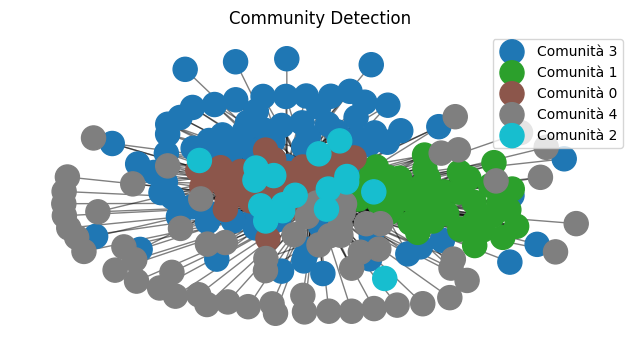

In [ ]:
# Creazione della mappa di colori
n_communities = len(communities)
custom_colors = plt.cm.get_cmap("tab10", n_communities)

# Disegno del grafo
plt.figure(figsize=(8, 4))

# Posizionamento dei nodi usando un layout di spring
pos = nx.spring_layout(grafo_utenti)

# Disegna i nodi e gli archi
for i, (community, nodes) in enumerate(communities.items()):
    nx.draw_networkx_nodes(grafo_utenti, pos, nodelist=nodes, node_color=[custom_colors(i)] * len(nodes), label=f"Comunità {community}")
    
# Disegna gli archi
nx.draw_networkx_edges(grafo_utenti, pos, alpha=0.5)


# Aggiungere una legenda
plt.legend(scatterpoints=1)
plt.title("Community Detection")
plt.axis('off')  # Nascondi gli assi
plt.show()

In [ ]:
# Funzione per ottenere i commenti di un video come dizionario
def newget_video_comments(api_key, video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments_dict = {}
    next_page_token = None

    while True:

            comment_request = youtube.commentThreads().list(
                part='snippet',
                videoId=video_id,
                textFormat='plainText',
                maxResults=100,
                pageToken=next_page_token
            )
            comment_response = comment_request.execute()

            if 'items' in comment_response:  # Controlla se ci sono commenti
                for item in comment_response['items']:
                    commenter = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
                    comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                    comments_dict[commenter] = comment  # Aggiungi al dizionario

            next_page_token = comment_response.get('nextPageToken')
            if not next_page_token:
                break

    return comments_dict

# Titolo della playlist da cercare
playlist_title = "Let's Play Pokemon Platino"

# Recuperare l'ID della playlist
playlists = get_playlist_id(API_KEY, channel_id, playlist_title)
if playlists:
    playlist_id = playlists[0][0]  # Prendi il primo ID trovato
    print(f"Trovata playlist: {playlists[0][1]} con ID: {playlist_id}")
    
    # Recuperare i video dalla playlist
    video_ids = get_playlist_videos(API_KEY, playlist_id)

    # Recuperare e aggregare i commenti da tutti i video in un dizionario
    all_comments_dict = {}
    
for video_id, title in video_ids:  # Assicurati di estrarre solo l'ID
    print(f"Recupero commenti per il video: {video_id}")
    comments_dict = newget_video_comments(API_KEY, video_id)  # Passa solo l'ID
    all_comments_dict.update(comments_dict)  # Unisci i dizionari


    # Stampa il dizionario degli utenti e dei loro commenti
    print("Dizionario degli utenti e dei loro commenti:")
    for user, comment in all_comments_dict.items():
        print(f"{user}: {comment}")
else:
    print("Nessuna playlist trovata.")

tro il primo superquattro :) 
@davidetarovo4671: Ahahahah "non uso le caramelle rare" cit
@danielecoletti: Finalmente mi sono recuperato tutti gli episodi. (Stupidi esami😁)
@lucacamagna1608: YEEEH finalmente posso dirlo prima che spunti un Haou Sama selvatico. Se vuoi completare l'LP al 100% c'è ancora la sfida degli Unown, di solito queste cose le fai prima dei leggendari, te lo dico perchè potresti esserten dimenticato :c
@christianbacchilega6984: Primo
@umbertoforlani4677: A mio parere il team non è molto oroginale
@pinguinosovietico7051: io che dopo sei anni vedo sto sto video nella home
@docdrew17: 6:34 si ma che senso ha leggere tutte le mosse dei pokemon nemici prima della lotta? è come barare, grazie al cazzo che pensavi fosse più difficile la battaglia😅
@filomenafranzese7530: Tonx pokemon Platinum l ho finito con mio zio
@vincenzomusto641: Chi qua dopo il remake di Diamante e Perla?
@sceptile7: Tonx: "siamo molto, molto, molto underlevellati"
Io con i Pokémon lv. 49-50-51: "Ar

In [ ]:
# Funzione per analizzare i commenti di una community
def analyze_comments(comments):
    all_comments = ' '.join(comments)
    
    words = nltk.word_tokenize(all_comments)
    
    stop_words = set(stopwords.words('italian')) 
    filtered_words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
    
    word_counts = Counter(filtered_words)
    
    return word_counts.most_common(10)  # Restituisci le 10 parole più comuni con il loro conteggio

# Dizionario per memorizzare le parole più utilizzate in ogni comunità
common_words_dict = {}

# Analizza i commenti per ogni community
for community_id, members in communities.items():
    community_comments = [all_comments_dict[members] for members in members if members in all_comments_dict]
    if community_comments:
        print(f"\nParole più usate in Comunità {community_id}:")
        most_common_words = analyze_comments(community_comments)
        
        # Memorizza solo le parole nel dizionario
        common_words_dict[community_id] = [word for word, _ in most_common_words]
        
        # Mostra le parole con i rispettivi conteggi
        for word, count in most_common_words:
            print(f"{word}: {count}")
    else:
        print(f"Comunità {community_id} non ha commenti disponibili.")

# Stampa il dizionario delle parole più utilizzate in ciascuna comunità
print("\nDizionario delle parole più utilizzate in ciascuna comunità:")
for community_id, words in common_words_dict.items():
    print(f"Comunità {community_id}: {words}")


Parole più usate in Comunità 3:
Tonx: 7
video: 4
pokemon: 4
me: 3
quando: 3
mai: 3
comunque: 3
Raga: 2
fatto: 2
Pokémon: 2

Parole più usate in Comunità 0:
video: 8
play: 8
Tonx: 7
let: 7
quando: 4
parte: 4
bel: 3
gioco: 3
platino: 3
leggendari: 3

Parole più usate in Comunità 2:
Tonx: 7
platino: 5
fa: 5
quando: 5
fare: 4
cosa: 4
Ke: 4
gioco: 4
Grande: 3
tonx: 3

Parole più usate in Comunità 1:
Tonx: 10
video: 9
tonx: 8
pokemon: 7
fare: 6
poi: 5
cattura: 5
catturato: 4
parte: 4
é: 4

Parole più usate in Comunità 4:
Tonx: 3
uova: 2
quando: 2
catturai: 2
pc: 2
grande: 2
tonx: 2
video: 2
SIIIIIIIIIIIII: 1
DIAMINE: 1

Dizionario delle parole più utilizzate in ciascuna comunità:
Comunità 3: ['Tonx', 'video', 'pokemon', 'me', 'quando', 'mai', 'comunque', 'Raga', 'fatto', 'Pokémon']
Comunità 0: ['video', 'play', 'Tonx', 'let', 'quando', 'parte', 'bel', 'gioco', 'platino', 'leggendari']
Comunità 2: ['Tonx', 'platino', 'fa', 'quando', 'fare', 'cosa', 'Ke', 'gioco', 'Grande', 'tonx']
Comunità 1

In [ ]:
# Inizializza un dizionario per memorizzare le intersezioni
intersezioni = {}

# Ottieni gli ID delle comunità
community_ids = list(common_words_dict.keys())

# Calcolo delle intersezioni tra tutte le comunità
for i in range(len(community_ids)):
    community_1 = community_ids[i]
    intersezioni[community_1] = {}  # Inizializza un dizionario per l'intersezione della comunità corrente

    for j in range(len(community_ids)):
        if i != j:  # Evita di confrontare la comunità con se stessa
            community_2 = community_ids[j]
            intersezione = 0  # Reset dell'intersezione per ogni coppia di comunità
            
            # Confronta le parole della comunità corrente con l'altra comunità
            for word in common_words_dict[community_1]:
                if word in common_words_dict[community_2]:
                    intersezione += 1  # Incrementa l'intersezione se la parola è comune
            
            # Memorizza l'intersezione nel dizionario
            intersezioni[community_1][community_2] = intersezione

# Se desideri stampare il dizionario delle intersezioni
print("\nDizionario delle intersezioni:")
for community, inters in intersezioni.items():
    print(f"Comunità {community}: {inters}")


Dizionario delle intersezioni:
Comunità 3: {0: 3, 2: 2, 1: 3, 4: 3}
Comunità 0: {3: 3, 2: 4, 1: 3, 4: 3}
Comunità 2: {3: 2, 0: 4, 1: 3, 4: 3}
Comunità 1: {3: 3, 0: 3, 2: 3, 4: 3}
Comunità 4: {3: 3, 0: 3, 2: 3, 1: 3}


In [ ]:
# Funzione per ottenere i commenti di un video
def get_video_comments2(api_key, video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    next_page_token = None

    while True:
        comment_request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat='plainText',
            maxResults=100,
            pageToken=next_page_token
        )
        comment_response = comment_request.execute()

        for item in comment_response['items']:
            comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment_text)  # Aggiungi solo il testo del commento

        next_page_token = comment_response.get('nextPageToken')
        if not next_page_token:
            break

    return comments
# Funzione principale per ottenere il dizionario dei commenti dalla playlist
def get_comments_dict(api_key, channel_name, playlist_title):
    channel_id = get_channel_id(api_key, channel_name)
    playlists = get_playlist_id(api_key, channel_id, playlist_title)

    comments_dict = {}
    for playlist_id, title in playlists:
        videos = get_playlist_videos(api_key, playlist_id)
        for video_id, video_title in videos:
            comments = get_video_comments2(api_key, video_id)
            comments_dict[video_id] = comments

    return comments_dict

# Esegui la funzione principale
comments_dictionary = get_comments_dict(API_KEY, CHANNEL_NAME, "Let's Play Pokemon Platino")

# Stampa il dizionario dei commenti
for video_id, comments in comments_dictionary.items():
    print(f"Video ID: {video_id}, Commenti: {comments}")

Video ID: K-ETA4lEszQ, Commenti: ['Forse avrò guardato 3/4 volte l’intera saga di questo gioco.sei veramente unico,complimenti!!io ho un grosso problema,non riesco a trovare il fossile di cranidos,avrò trovato tutti i fossili non so quante volte,compresi quelli di kanto,ma non trovo lui.consigli?', 'Platino resta ancora migliore di Diamante Lucente e Perla Splendente.', 'Awww il giovane tonks', 'Chi come me nel 2024 ora ho 25 anni😢😢😢', '2023 e piango qua 😢', 'barry è IPERATTIVO', '2022 rewach', 'Dopo anni sono ancora qui', 'Quanto era diversa non diceva neanche il sui saluto🥲', 'Platino insieme a diamante e perla, i miei primi giochi Pokémon, una nostalgia nel sentire queste musiche e vedere questi posti🥲', "Tonx te avevi preso eevee di cattura eevee l'hai chiamato espeonage poi l'hai fatto evolvere in espeon allora io prenderò eevee e lo chiamerò jolteonage perché quando trovo una pietratuono lo farò evolvere in jolteon perché mi piace un sacco jolteon ed di tipo elettro è ah me I mie

/root/venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


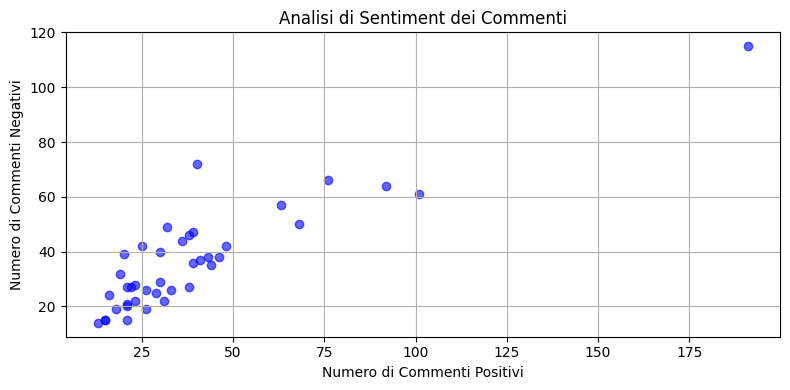

In [ ]:
# Funzione per analizzare il sentiment e calcolare il numero di commenti positivi e negativi
def analyze_sentiment(comments_dict):
    sentiment_clf = SentimentClassifier()
    results = {}

    for video_id, comments in comments_dict.items():
        positive_count = 0
        negative_count = 0

        for comment in comments:
            frase = [comment]  # Creiamo una lista con il commento
            sentiment = sentiment_clf.predict(frase)
            if sentiment[0] == 'positive':
                positive_count += 1
            elif sentiment[0] == 'negative':
                negative_count += 1

        results[video_id] = (positive_count, negative_count)

    return results

# Funzione per plottare i risultati
def plot_sentiment_ratios(results):
    video_ids = list(results.keys())
    positive_counts = [result[0] for result in results.values()]
    negative_counts = [result[1] for result in results.values()]

    plt.figure(figsize=(8, 4))
    plt.scatter(positive_counts, negative_counts, color='blue', alpha=0.6)

    plt.title('Analisi di Sentiment dei Commenti')
    plt.xlabel('Numero di Commenti Positivi')
    plt.ylabel('Numero di Commenti Negativi')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

last50 = {}

# Prendi i primi 3 elementi
for i, (chiave, valore) in enumerate(comments_dictionary.items()):
    if i < 40:  # Modifica qui per ottenere i primi 50 elementi
        last50[chiave] = valore
    else:
        break

# Analizza il sentiment dei commenti
sentiment_results = analyze_sentiment(last50)

# Plotta i risultati
plot_sentiment_ratios(sentiment_results)


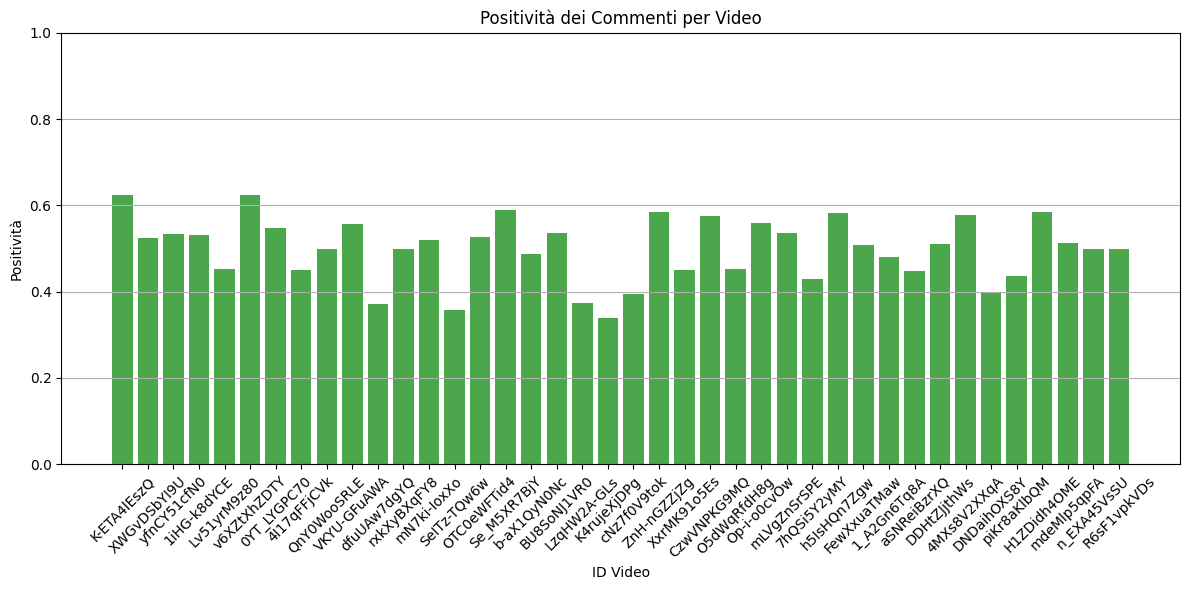

In [ ]:
# Funzione per calcolare la positività per ogni video
def calculate_positivity(video_data):
    results = {}
    for video_id, (positive_count, negative_count) in video_data.items():
        total_comments = positive_count + negative_count
        
        if total_comments > 0:
            positivity = positive_count / total_comments  # Calcolo della positività
        else:
            positivity = 0
        
        results[video_id] = {
            'positivi': positive_count,
            'negativi': negative_count,
            'positività': positivity
        }
    
    return results

# Funzione per plottare la positività per ogni video
def plot_positivity(results):
    video_ids = list(results.keys())
    positivity = [result['positività'] for result in results.values()]

    plt.figure(figsize=(12, 6))

    # Creazione del grafico a barre
    plt.bar(video_ids, positivity, color='green', alpha=0.7)

    plt.title('Positività dei Commenti per Video')
    plt.xlabel('ID Video')
    plt.ylabel('Positività')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Limiti dell'asse y da 0 a 1
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Calcola la positività per i video
positivity_results = calculate_positivity(sentiment_results)

# Plotta la positività per ogni video
plot_positivity(positivity_results)

In [ ]:
# Funzione per trovare i primi 5 video con la positività maggiore
def top_5_positive_videos(positivity_results, video_titles):
    # Ordinare i video in base alla positività
    sorted_videos = sorted(positivity_results.items(), key=lambda item: item[1]['positività'], reverse=True)
    
    # Ottenere i primi 5 video
    top_5 = sorted_videos[:5]
    best = {}
    titles_dict = dict(video_commenti)
    # Mostrare i titoli e la positività
    for video_id, data in top_5:
        title = titles_dict[video_id]
        positivity = data['positività']
        print(f'ID: {video_id}, Titolo: {title}, Positività: {positivity:.2f}')
        best[video_id] = title
    return best

# Trova e stampa i primi 5 video con la positività maggiore
top_5 = top_5_positive_videos(positivity_results, video_commenti)

ID: K-ETA4lEszQ, Titolo: Pokemon Platino ITA [Parte 1 - Si comincia!], Positività: 0.62
ID: v6XZtXhZDTY, Titolo: Pokemon Platino ITA [Parte 6 - Giardinfiorito], Positività: 0.62
ID: Se_M5XR7BjY, Titolo: Pokemon Platino ITA [Parte 16 - Fannie], Positività: 0.59
ID: ZnH-nGZZjZg, Titolo: Pokemon Platino ITA [Parte 22 - Pioggia], Positività: 0.58
ID: H1ZDidh4OME, Titolo: Pokemon Platino ITA [Parte 37 - Isola Ferrosa], Positività: 0.58


In [ ]:
# Analisi dei commenti dei video migliori
for video_id in top_5:
    comments = comments_dictionary.get(video_id, [])
    common_words = analyze_comments(comments)
    
    print(f'=== Analisi per {title} (ID: {video_id}) ===')
    print('Parole più comuni:')
    for word, count in common_words:
        print(f'- {word}: {count}')
    print()  # Spazio tra le analisi

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: K-ETA4lEszQ) ===
Parole più comuni:
- pokemon: 57
- gioco: 40
- Tonx: 26
- platino: 25
- quando: 20

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: v6XZtXhZDTY) ===
Parole più comuni:
- pokemon: 29
- shaymin: 12
- buizel: 12
- Tonx: 11
- me: 11

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: Se_M5XR7BjY) ===
Parole più comuni:
- pokemon: 21
- leone: 21
- shinx: 16
- Regulus: 15
- stella: 15

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: ZnH-nGZZjZg) ===
Parole più comuni:
- Tonx: 9
- pokemon: 6
- machop: 5
- me: 5
- Conan: 5

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: H1ZDidh4OME) ===
Parole più comuni:
- Tonx: 12
- pokemon: 9
- video: 8
- team: 7
- ferrosa: 4



In [ ]:
def top_5_negative_videos(positivity_results, video_titles):
    # Ordinare i video in base alla positività in ordine crescente
    sorted_videos = sorted(positivity_results.items(), key=lambda item: item[1]['positività'])
    
    # Ottenere i primi 5 video
    top_5 = sorted_videos[:5]
    best = {}
    titles_dict = dict(video_titles)  # Assicurati che tu abbia il dizionario corretto per i titoli
    # Mostrare i titoli e la positività
    for video_id, data in top_5:
        title = titles_dict[video_id]
        positivity = data['positività']
        print(f'ID: {video_id}, Titolo: {title}, Positività: {positivity:.2f}')
        best[video_id] = title
    return best

# Trova e stampa i primi 5 video con la positività minore
topN_5 = top_5_negative_videos(positivity_results, video_commenti)

ID: K4rujeXjDPg, Titolo: Pokemon Platino ITA [Parte 20 - Torre Memoria], Positività: 0.34
ID: SeITz-TQw6w, Titolo: Pokemon Platino ITA [Parte 14 - Antico Chateau], Positività: 0.36
ID: dfuUAw7dgYQ, Titolo: Pokemon Platino ITA [Parte 11 - Sottoterra], Positività: 0.37
ID: LzqHW2A-GLs, Titolo: Pokemon Platino ITA [Parte 19 - Rovine Flemminia], Positività: 0.37
ID: cNz7f0V9tok, Titolo: Pokemon Platino ITA [Parte 21 - Milkshake], Positività: 0.40


In [ ]:
for video_id in topN_5:
    comments = comments_dictionary.get(video_id, [])
    common_words = analyze_comments(comments)
    
    print(f'=== Analisi per {title} (ID: {video_id}) ===')
    print('Parole più comuni:')
    for word, count in common_words:
        print(f'- {word}: {count}')
    print()  # Spazio tra le analisi

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: K4rujeXjDPg) ===
Parole più comuni:
- Tonx: 11
- fa: 6
- Spiritomb: 5
- pokemon: 5
- tonx: 5

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: SeITz-TQw6w) ===
Parole più comuni:
- me: 20
- rotom: 17
- video: 13
- poi: 11
- anni: 11

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: dfuUAw7dgYQ) ===
Parole più comuni:
- Tonx: 7
- sotterranei: 4
- fatto: 4
- video: 4
- casino: 4

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: LzqHW2A-GLs) ===
Parole più comuni:
- Tonx: 10
- espeon: 7
- secondo: 7
- detto: 6
- me: 5

=== Analisi per Pokemon Platino ITA [Parte 90 - Biblioteca di Canalipoli] (ID: cNz7f0V9tok) ===
Parole più comuni:
- Tonx: 11
- pokemon: 10
- fangosberla: 9
- mossa: 8
- tonx: 7



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c0129d4-1c28-4a60-b6a1-1e26bf403598' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>